In [16]:
import numpy as np
np.random.seed(42)
class Autoencoder:
    def __init__(self, d, n1):
        self.d = d
        self.n1 = n1

        self.W1 = np.random.uniform(-np.sqrt(6 / (d + n1)), np.sqrt(6 / (d + n1)), (n1, d))
        self.W2 = np.random.uniform(-np.sqrt(6 / (d + n1)), np.sqrt(6 / (d + n1)), (d, n1))
        self.b1 = np.zeros((n1, 1))
        self.b2 = np.zeros((d, 1))

        self.timestep = 0
        self.nu_W1 = np.zeros_like(self.W1)
        self.nu_W2 = np.zeros_like(self.W2)
        self.nu_b1 = np.zeros_like(self.b1)
        self.nu_b2 = np.zeros_like(self.b2)
        self.h_W1 = np.zeros_like(self.W1)
        self.h_W2 = np.zeros_like(self.W2)
        self.h_b1 = np.zeros_like(self.b1)
        self.h_b2 = np.zeros_like(self.b2)

    def h1(self, a):
        return np.maximum(0, a)

    def h2(self, a):
        return 1 / (1 + np.exp(-a))

    def dh1(self, a):
        return np.where(a > 0, 1, 0)

    def dh2(self, a):
        sigmoid = self.h2(a)
        return sigmoid * (1 - sigmoid)

    def loss(self, Xbatch):
        Ybatch = self.forward(Xbatch)
        return -np.mean(Xbatch * np.log(Ybatch) + (1 - Xbatch) * np.log(1 - Ybatch))

    def dloss(self, Ybatch):
        Xbatch = self.Xbatch
        return (-1/self.d)*(Xbatch/Ybatch - (1-Xbatch)/(1-Ybatch))

    def forward(self, Xbatch):
        self.Xbatch = Xbatch
        self.a1 = self.W1 @ Xbatch + self.b1
        self.o1 = self.h1(self.a1)
        self.a2 = self.W2 @ self.o1 + self.b2
        self.o2 = self.h2(self.a2)
        return self.o2

    def backward(self):
        m = self.Xbatch.shape[1]
        da2 = self.dloss(self.o2) * self.dh2(self.a2)
        self.dW2 = da2 @ self.o1.T / m
        self.db2 = np.sum(da2, axis=1, keepdims=True) / m
        da1 = self.W2.T @ da2 * self.dh1(self.a1)
        self.dW1 = da1 @ self.Xbatch.T / m
        self.db1 = np.sum(da1, axis=1, keepdims=True) / m

    def adam_step(self, alpha=0.001, rho1=0.9, rho2=0.999, delta=1e-8):
        self.timestep += 1
        w1 = [self.W1,self.dW1,self.nu_W1,self.h_W1]
        w2 = [self.W2,self.dW2,self.nu_W2,self.h_W2]
        b1 = [self.b1,self.db1,self.nu_b1,self.h_b1]
        b2 = [self.b2,self.db2,self.nu_b2,self.h_b2]
        for param, dparam, nu, h in (w1,w2,b1,b2):
            nu[:] = rho1 * nu + (1 - rho1) * dparam
            h[:] = rho2 * h + (1 - rho2) * (dparam * dparam)
            nu_hat = nu / (1 - rho1**self.timestep)
            h_hat = h / (1 - rho2**self.timestep)
            param -= alpha * nu_hat / (np.sqrt(h_hat) + delta)



In [17]:
import torchvision

# Load the Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform).data.numpy()
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform).data.numpy()

# Scale and reshape the data
x_train = train_dataset.reshape((train_dataset.shape[0], -1)).T / 255
x_test = test_dataset.reshape((test_dataset.shape[0], -1)).T / 255

# Train the autoencoder
d = x_train.shape[0]
n1 = 100
num_epochs = 100
minibatch_size = 256
num_splits = x_train.shape[1] // minibatch_size

ae = Autoencoder(d, n1)
for e in range(num_epochs):
    print("Training loss [%d/%d]: %.2f" % (e + 1, num_epochs, ae.loss(x_train)))
    minibatches = np.array_split(np.random.permutation(x_train.shape[1]), num_splits)
    for indices in minibatches:
        Xbatch = x_train[:, indices]
        ae.forward(Xbatch)
        ae.backward()
        ae.adam_step()

Training loss [1/100]: 0.70
Training loss [2/100]: 0.32
Training loss [3/100]: 0.30
Training loss [4/100]: 0.28
Training loss [5/100]: 0.28
Training loss [6/100]: 0.28
Training loss [7/100]: 0.27
Training loss [8/100]: 0.27
Training loss [9/100]: 0.27
Training loss [10/100]: 0.27
Training loss [11/100]: 0.27
Training loss [12/100]: 0.27
Training loss [13/100]: 0.27
Training loss [14/100]: 0.27
Training loss [15/100]: 0.27
Training loss [16/100]: 0.27
Training loss [17/100]: 0.27
Training loss [18/100]: 0.27
Training loss [19/100]: 0.27
Training loss [20/100]: 0.27
Training loss [21/100]: 0.26
Training loss [22/100]: 0.26
Training loss [23/100]: 0.26
Training loss [24/100]: 0.26
Training loss [25/100]: 0.26
Training loss [26/100]: 0.26
Training loss [27/100]: 0.26
Training loss [28/100]: 0.26
Training loss [29/100]: 0.26
Training loss [30/100]: 0.26
Training loss [31/100]: 0.26
Training loss [32/100]: 0.26
Training loss [33/100]: 0.26
Training loss [34/100]: 0.26
Training loss [35/100]:

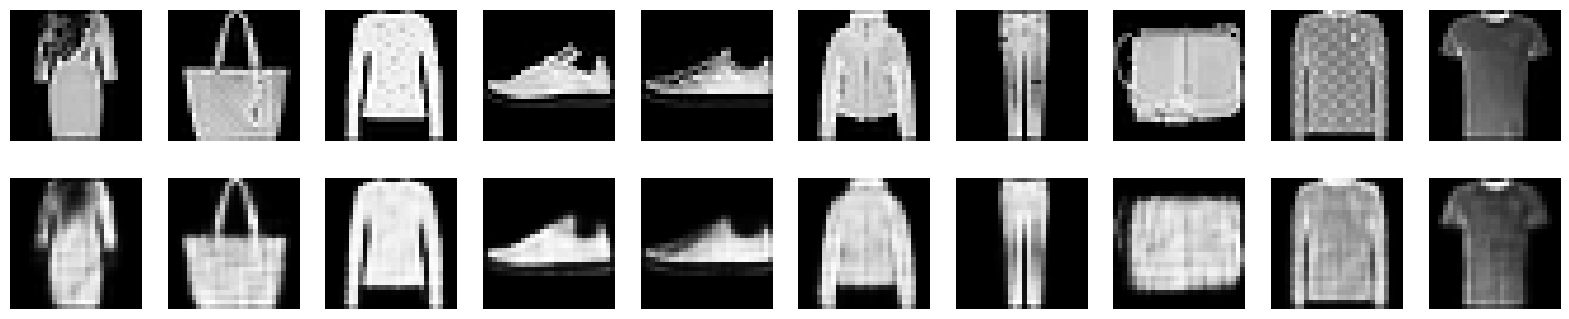

Final loss on test set: 0.2654257044448121
Hyperparameters:
  n1 = 100
  num_epochs = 100
  minibatch_size = 256


In [18]:
import matplotlib.pyplot as plt

# Select 10 random images from the test set
indices = np.random.choice(x_test.shape[1], 10, replace=False)
X_selected = x_test[:, indices]
Y_selected = ae.forward(X_selected)

# Display the images and their reconstructions
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for i in range(10):
    # Original images
    ax = axes[0, i]
    ax.imshow(X_selected[:, i].reshape((28, 28)), cmap='gray')
    ax.axis('off')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(Y_selected[:, i].reshape((28, 28)), cmap='gray')
    ax.axis('off')

plt.show()

# Print test set loss and hyperparameters
print("Final loss on test set:", ae.loss(x_test))
print("Hyperparameters:")
print("  n1 =", n1)
print("  num_epochs =", num_epochs)
print("  minibatch_size =", minibatch_size)
